In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nursery/nursery.csv


# Load

In [8]:
columns = ['parents', 'has_nurs', 'form', 'children', 'housing', 'finance', 'social', 'health', 'final evaluation']

X_trains = {}
X_tests = {}
y_trains = {}
y_tests = {}

nursery = pd.read_csv('/kaggle/input/nursery/nursery.csv')
print(nursery.head())

X_nursery = nursery.drop('final evaluation', axis='columns')
y_nursery = nursery['final evaluation']

X_trains['raw'], X_tests['raw'], y_trains['raw'], y_tests['raw'] = model_selection.train_test_split(X_nursery, y_nursery, test_size=0.2, random_state=25)

  parents has_nurs      form children     housing     finance         social  \
0   usual   proper  complete        1  convenient  convenient        nonprob   
1   usual   proper  complete        1  convenient  convenient        nonprob   
2   usual   proper  complete        1  convenient  convenient        nonprob   
3   usual   proper  complete        1  convenient  convenient  slightly_prob   
4   usual   proper  complete        1  convenient  convenient  slightly_prob   

        health final evaluation  
0  recommended        recommend  
1     priority         priority  
2    not_recom        not_recom  
3  recommended        recommend  
4     priority         priority  


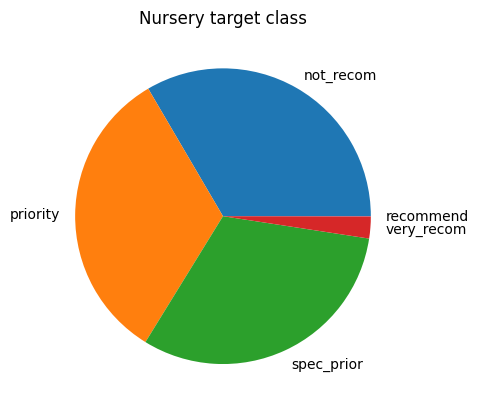

In [9]:
y_trains['raw'].value_counts().plot(kind='pie', ylabel='')
plt.title('Nursery target class')
plt.savefig('nursery-y.png')

# Pre-process

## Transform ordinal attributes

In [10]:
# Identify categorical columns
cols_cat = [c for c in X_trains['raw'].columns if X_trains['raw'][c].dtype == 'O']

# Specify ordinal values for certain columns
cols_ordinal_values = {
    'parents': ['usual', 'pretentious', 'great_pret'],
    'has_nurs': ['proper', 'less_proper', 'improper', 'critical', 'very_crit'],
    'form': ['complete', 'completed', 'incomplete', 'foster'],
    'children': ['1', '2', '3', 'more'],
    'housing': ['convenient', 'less_conv', 'critical'],
    'finance': ['convenient', 'inconv'],
    'social': ['nonprob', 'slightly_prob', 'problematic'],
    'health': ['recommended', 'priority', 'not_recom']
}

# Identify ordinal columns
cols_ordinal = list(cols_ordinal_values.keys())

# Identify nominal columns
cols_nominal = list(set(cols_cat) - set(cols_ordinal))

# Print the identified columns
print("Categorical Columns:", cols_cat)
print("Ordinal Columns:", cols_ordinal)
print("Nominal Columns:", cols_nominal)

Categorical Columns: ['parents', 'has_nurs', 'form', 'children', 'housing', 'finance', 'social', 'health']
Ordinal Columns: ['parents', 'has_nurs', 'form', 'children', 'housing', 'finance', 'social', 'health']
Nominal Columns: []


## One-hot encoding

In [11]:
# # One-hot encode the training set
# X_trains['onehot'] = pd.get_dummies(X_trains['raw'], columns=columns[:-1])
# X_trains['onehot'].head()

In [12]:
# One-hot encode the columns in the training and test datasets
temp_nursery = pd.get_dummies(pd.concat([X_trains['raw'], X_tests['raw']], keys=[0, 1]), columns=cols_cat)
X_trains['onehot'], X_tests['onehot'] = temp_nursery.xs(0), temp_nursery.xs(1)
X_trains['onehot'].head()

,parents_great_pret,parents_pretentious,parents_usual,has_nurs_critical,has_nurs_improper,has_nurs_less_proper,has_nurs_proper,has_nurs_very_crit,form_complete,form_completed,...,housing_critical,housing_less_conv,finance_convenient,finance_inconv,social_nonprob,social_problematic,social_slightly_prob,health_not_recom,health_priority,health_recommended
1731,False,False,True,False,True,False,False,False,True,False,...,False,False,True,False,False,False,True,False,False,True
8230,False,True,False,False,False,False,False,True,False,False,...,False,True,True,False,False,False,True,False,True,False
6369,False,True,False,False,True,False,False,False,False,True,...,True,False,False,True,False,True,False,False,False,True
2877,False,False,True,True,False,False,False,False,False,True,...,False,False,False,True,False,True,False,False,False,True
11765,True,False,False,True,False,False,False,False,False,False,...,True,False,False,True,True,False,False,True,False,False


## Label encoding

In [13]:
for X in [X_trains, X_tests]:
    # Label encoding on ordinal attributes
    df_nursery = X['raw'].copy()
    enc_nursery = OrdinalEncoder(categories=[l for l in cols_ordinal_values.values()])
    df_nursery[list(cols_ordinal_values.keys())] = enc_nursery.fit_transform(df_nursery[list(cols_ordinal_values.keys())])
    df_nursery[list(cols_ordinal_values.keys())] = df_nursery[list(cols_ordinal_values.keys())].astype('int32')

    X['onehot_label'] = df_nursery.copy()

temp_nursery = pd.get_dummies(pd.concat([X_trains['onehot_label'], X_tests['onehot_label']], keys=[0, 1]), columns=cols_nominal)
X_trains['onehot_label'], X_tests['onehot_label'] = temp_nursery.xs(0), temp_nursery.xs(1)

# Print the result
print("Result after label encoding and one-hot encoding:")
print("X_trains['onehot_label']:\n", X_trains['onehot_label'].head())
print("\nX_tests['onehot_label']:\n", X_tests['onehot_label'].head())

Result after label encoding and one-hot encoding:
X_trains['onehot_label']:
        parents  has_nurs  form  children  housing  finance  social  health
1731         0         2     0         0        0        0       1       0
8230         1         4     2         0        1        0       1       1
6369         1         2     1         1        2        1       2       0
2877         0         3     1         1        0        1       2       0
11765        2         3     2         1        2        1       0       2

X_tests['onehot_label']:
        parents  has_nurs  form  children  housing  finance  social  health
4865         1         0     2         2        0        0       1       2
6255         1         2     0         3        2        1       0       0
10567        2         2     0         3        2        0       0       1
7863         1         4     0         1        1        1       2       0
11923        2         3     3         0        2        0       2     

## Transform target to ordinal

In [14]:
# Define the order for encoding
order = ['not_recom', 'recommend', 'very_recom', 'priority', 'spec_prior']

# Apply encoding to the training set
y_trains['encoded'] = y_trains['raw'].apply(lambda x: order.index(x))

# Apply encoding to the test set
y_tests['encoded'] = y_tests['raw'].apply(lambda x: order.index(x))

print("Encoded values for the training set:")
print(y_trains['encoded'].value_counts())

print("\nEncoded values for the test set:")
print(y_tests['encoded'].value_counts())

Encoded values for the training set:
final evaluation
0    3467
3    3398
4    3252
2     249
1       2
Name: count, dtype: int64

Encoded values for the test set:
final evaluation
3    868
0    853
4    792
2     79
Name: count, dtype: int64


# Train

## Classifier 1 - k-nearest neighbours

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import metrics

gs_knn = {}
results_knn = []

for preprocess, X_train in X_trains.items():
    # Skip pre-processed DFs with string (categorical) values
    if len(X_train.select_dtypes(include='object', exclude=['number', 'bool']).columns):
        continue
    
    X_test = X_tests[preprocess]
    y_train = y_trains['encoded']
    y_test = y_tests['encoded']
    
    print(f"kNN on {preprocess} set: ")
    
    # Holdout set evaluation
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print(f"Original holdout training/test split - Accuracy: {knn.score(X_test, y_test)}" )

    # Cross-validation
    scores = cross_val_score(knn, X_train, y_train)
    print("CV fold accuracies:", scores)
    print("Accuracies: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))
    
    results_knn.append((preprocess, knn.score(X_test, y_test)))
    
    # Grid search
    kvals = list(range(1, 16))
    p = [1, 2]
    knng = GridSearchCV(
        estimator=knn,
        param_grid={'n_neighbors': kvals, 'p': p}
    )
    knng.fit(X_train, y_train)
    gs = pd.DataFrame.from_dict(knng.cv_results_)
    gs_knn[preprocess] = gs
    
    print("Grid search best score: %0.3f, Best Estimator: %f" % (knng.best_score_, knng.best_estimator_.n_neighbors))
    knn_result = knng.predict(X_test)
    print("Score on y_test ", knng.score(X_test, y_test))
    results_knn.append((preprocess, knng.score(X_test, y_test)))
    print(metrics.confusion_matrix(y_test, knn_result))
    print('----')

# Display results
results_knn = pd.DataFrame.from_records(results_knn, columns=['preprocess', 'test_accuracy'])
for t in ['onehot', 'label', 'log', 'minmax', 'z']:
    results_knn[t] = results_knn['preprocess'].str.contains(t)
results_knn.drop('preprocess', axis='columns', inplace=True)
print(results_knn.sort_values('test_accuracy', ascending=False).to_latex(index=False))

kNN on onehot set: 
Original holdout training/test split - Accuracy: 0.7885802469135802


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


CV fold accuracies: [0.78736741 0.77675988 0.78061716 0.79450072 0.77327545]
Accuracies: 0.783 (+/- 0.008)


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Grid search best score: 0.967, Best Estimator: 12.000000
Score on y_test  0.972608024691358
[[853   0   0   0]
 [  0  41  38   0]
 [  0   0 853  15]
 [  0   0  18 774]]
----
kNN on onehot_label set: 
Original holdout training/test split - Accuracy: 0.8560956790123457


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


CV fold accuracies: [0.83992285 0.86258438 0.85004822 0.85721177 0.87264834]
Accuracies: 0.856 (+/- 0.011)


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Grid search best score: 0.973, Best Estimator: 8.000000
Score on y_test  0.9903549382716049
[[853   0   0   0]
 [  0  72   7   0]
 [  0   0 862   6]
 [  0   0  12 780]]
----
\begin{tabular}{rrrrrr}
\toprule
test_accuracy & onehot & label & log & minmax & z \\
\midrule
0.990355 & True & True & False & False & False \\
0.972608 & True & False & False & False & False \\
0.856096 & True & True & False & False & False \\
0.788580 & True & False & False & False & False \\
\bottomrule
\end{tabular}



In [ ]:
legend = []
for preprocess, results in gs_knn.items():    
    for p in [1, 2]:
        plt.plot(results[results['param_p'] == p]['param_n_neighbors'], results[results['param_p'] == p][f'mean_test_score'])
        legend.append(f'{preprocess}, p={p} (L{p} dist)')
plt.xlabel('n_neighbors')
plt.ylabel(f'mean score')
plt.legend(legend)
plt.savefig('knn-loan-best.png')

## Classifier 2 - Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

gs_dt = {}
results_dt = []

for preprocess, X_train in X_trains.items():
    # Skip pre-processed DFs with string (categorical) values
    if len(X_train.select_dtypes(include='object', exclude=['number', 'bool']).columns):
        continue
    
    X_test = X_tests[preprocess]
    y_train = y_trains['encoded']
    y_test = y_tests['encoded']
    
    print(f"Decision Tree on {preprocess} set: ")
    
    # Holdout set evaluation
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    print(f"Original holdout training/test split - Accuracy: {dt.score(X_test, y_test)}" )

    # Cross-validation
    scores = cross_val_score(dt, X_train, y_train)
    print("CV fold accuracies:", scores)
    print("Accuracies: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))
    
    results_dt.append((preprocess, dt.score(X_test, y_test)))
    
    # Grid search
    param_grid = {
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    dt_grid = GridSearchCV(estimator=dt, param_grid=param_grid)
    dt_grid.fit(X_train, y_train)
    gs = pd.DataFrame.from_dict(dt_grid.cv_results_)
    gs_dt[preprocess] = gs
    
    print("Grid search best score: %0.3f, Best Estimator: %s" % (dt_grid.best_score_, dt_grid.best_estimator_))
    dt_result = dt_grid.predict(X_test)
    print("Score on y_test ", dt_grid.score(X_test, y_test))
    results_dt.append((preprocess, dt_grid.score(X_test, y_test)))
    print(metrics.confusion_matrix(y_test, dt_result))
    print('----')

# Display results
results_dt = pd.DataFrame.from_records(results_dt, columns=['preprocess', 'test_accuracy'])
for t in ['onehot', 'label', 'log', 'minmax', 'z']:
    results_dt[t] = results_dt['preprocess'].str.contains(t)
results_dt.drop('preprocess', axis='columns', inplace=True)
print(results_dt.sort_values('test_accuracy', ascending=False).to_latex(index=False))


## Classifier 3 - Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix

# Dictionary to store grid search results for different preprocessing methods
gs_lr = {}
results_lr = []

# Loop over preprocessed data
for preprocess, X_train in X_trains.items():
    # Skip pre-processed DFs with string (categorical) values
    if len(X_train.select_dtypes(include='object', exclude=['number', 'bool']).columns):
        continue
    
    X_test = X_tests[preprocess]
    y_train = y_trains['encoded']
    y_test = y_tests['encoded']
    
    print(f"Logistic Regression on {preprocess} set:")
    
    # Logistic Regression model
    lr = LogisticRegression(random_state=25, max_iter=10000, multi_class='multinomial') 

    # Holdout set evaluation
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f"Original holdout training/test split - Accuracy: {lr.score(X_test, y_test)}")

    # Cross-validation
    scores = cross_val_score(lr, X_train, y_train)
    print("CV fold accuracies:", scores)
    print("Accuracies: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))

    # Grid search for hyperparameter tuning
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    lrg = GridSearchCV(
        estimator=lr,
        param_grid=param_grid
    )
    lrg.fit(X_train, y_train)
    gs = pd.DataFrame.from_dict(lrg.cv_results_)
    gs_lr[preprocess] = gs
    
    print("Grid search best score: %0.3f, Best Estimator: %f" % (lrg.best_score_, lrg.best_estimator_.C))
    lrresult = lrg.predict(X_test)
    results_lr.append((preprocess, lrg.score(X_test,y_test)))
    print("Logistic Regression ", lrg.score(X_test, y_test))
    print(confusion_matrix(y_test, lrresult))

results_lr = pd.DataFrame.from_records(results_lr, columns=['preprocess', 'test_accuracy'])
for t in ['onehot', 'label', 'log', 'minmax', 'z']:
    results_lr[t] = results_lr['preprocess'].str.contains(t)
results_lr.drop('preprocess', axis='columns', inplace=True)
results_lr

In [ ]:
print(results_lr.to_latex(index=False))